In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchvision
from torchvision.transforms import transforms
from torchvision import models
import matplotlib.pyplot as plt

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd

file_id = "1WZLFr195SGw2_UCzis-Djuov8c4HJPk1"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_label.csv')

file_id = "1EixCdXLWw-tOh1ONlbIcQVTdw865c3sn"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_image.npz')

file_id = "1RYZe6fiviC1ReJZb4H5B6nVb2-vUoEx7"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_label.csv')

file_id = "1WE6ntEDaXWAGMiphJqwG6uKGr-HxkV6Y"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_image.npz')

CXR_label = pd.read_csv('CXR_label.csv')
CXR_data = np.load(file='CXR_image.npz')
CXR_data_3d = CXR_data['arr']

CT_label = pd.read_csv('CT_label.csv')
CT_data = np.load(file='CT_image.npz')
CT_data_3d = CT_data['arr']


Split data set

In [ ]:
CT_cov = CT_label[CT_label['finding']=='COVID-19']
CT_nor = CT_label[CT_label['finding']=='Normal']
CT_pne = CT_label[CT_label['finding']=='Pneumonia']

CXR_cov = CXR_label[CXR_label['finding']=='COVID-19']
CXR_nor = CXR_label[CXR_label['finding']=='Normal']
CXR_pne = CXR_label[CXR_label['finding']=='Pneumonia']

In [ ]:
train_label = []
train_CT = []
train_CXR = []

for i in range(300):

  CTimg1 = CT_data_3d[CT_cov.index[i]]
  CXRimg1 = CXR_data_3d[CXR_cov.index[i]]

  train_label.append(2)
  train_CT.append(CTimg1)
  train_CXR.append(CXRimg1)


  CTimg2 = CT_data_3d[CT_nor.index[i]]
  CXRimg2 = CXR_data_3d[CXR_nor.index[i]]

  train_CT.append(CTimg2)
  train_CXR.append(CXRimg2)
  train_label.append(0)

  CTimg3 = CT_data_3d[CT_pne.index[i]]
  CXRimg3 = CXR_data_3d[CXR_pne.index[i]]

  train_CT.append(CTimg3)
  train_CXR.append(CXRimg3)
  train_label.append(1)

train_CXR = np.array(train_CXR)
train_CT = np.array(train_CT)
train_label = np.array(train_label)

In [ ]:
test_CXR = []
test_CT = []
test_label = []


for i in range(300,325):

  CTimg1 = CT_data_3d[CT_cov.index[i]]
  CXRimg1 = CXR_data_3d[CXR_cov.index[i]]
  
  test_CT.append(CTimg1)
  test_CXR.append(CXRimg1)
  test_label.append(2)

  CTimg2 = CT_data_3d[CT_nor.index[i]]
  CXRimg2 = CXR_data_3d[CXR_nor.index[i]]

  test_CT.append(CTimg2)
  test_CXR.append(CXRimg2)
  test_label.append(0)

  CTimg3 = CT_data_3d[CT_pne.index[i]]
  CXRimg3 = CXR_data_3d[CXR_pne.index[i]]

  test_CT.append(CTimg3)
  test_CXR.append(CXRimg3)
  #test_data.append(img3)
  test_label.append(1)

test_CXR = np.array(test_CXR)
test_CT = np.array(test_CT)
test_label = np.array(test_label)

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
def feature_extraction(data, model):
  inputs_ls = []
  outputs_ls = []
  for dat in data:
    inputs = data_transforms(dat)
    inputs_ls.append(inputs)
  del model.fc
  model.fc=lambda x:x

  for inputs in inputs_ls:
    inputs = torch.unsqueeze(inputs, dim=0)
    with torch.no_grad():
        outputs = model(inputs)
        outputs_ls.append(outputs)
        _, preds = torch.max(outputs, 1)
  return outputs_ls

In [ ]:
def fuse_data(CT_data,CXR_data,model,w =0.5):
  # CT
  CT_features = feature_extraction(CT_data, model)

  # CXR
  CXR_features = feature_extraction(CXR_data, model)
  output = []

  for i, (x,y) in enumerate(zip(CXR_features,CT_features)):
        CXR_fuse = x[0]*w
        CT_fuse = y[0]*(1-w)
        _fused_data = CXR_fuse + CT_fuse
        output.append(_fused_data)

  out = torch.stack(output,0)

  return out


In [ ]:
ResNet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
fused_train_feature = fuse_data(train_CT,train_CXR,ResNet)
fused_test_feature = fuse_data(test_CT,test_CXR,ResNet)

In [ ]:
y_train=torch.from_numpy(train_label)
y_test=torch.from_numpy(test_label)

x_train=fused_train_feature.float()
x_test=fused_test_feature.float()
y_train=y_train.long()
y_test=y_test.long()

train_dataset=TensorDataset(x_train,y_train)
test_dataset=TensorDataset(x_test,y_test)

In [ ]:
#mini-batch
train_dataloader = DataLoader(dataset=train_dataset,batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=test_dataset,batch_size=128, shuffle=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('trian_device:{}'.format(device.type))

trian_device:cpu


In [ ]:
model = models.resnet18(pretrained=True)

num_fc_in = model.fc.in_features

model.fc = nn.Linear(num_fc_in, 3)

FC = model.fc

model = FC.to(device)

loss_fc = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.5)  # step_size

In [ ]:
for epoch in range(100):

    running_loss = 0.0
    
    for i, sample_batch in enumerate(train_dataloader):
        inputs = sample_batch[0]
        labels = sample_batch[1]

        model.train()

        # GPU/CPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # foward
        outputs = model(inputs)
        mat = torch.zeros(len(labels), 3)
        y_trans = labels.view(-1, 1)
        labels = mat.scatter_(dim=1, index=y_trans, value=1)

        # loss
        loss = loss_fc(outputs, labels)

        loss.backward()

        optimizer.step()
        exp_lr_scheduler.step()

        #
        running_loss += loss.item()
    
        if i % 3 == 0:
            correct = 0
            total = 0
            model.eval()
            for images_test, labels_test in train_dataloader:
                images_test = images_test.to(device)
                labels_test = labels_test.to(device)

                outputs_test = model(images_test)
                _, prediction = torch.max(outputs_test, 1)
                correct += (torch.sum((prediction == labels_test))).item()
               # print(prediction, labels_test, correct)
                total += labels_test.size(0)
            print('[{}, {}] running_loss = {:.5f} train accurcay = {:.5f}'.format(epoch + 1, i + 1, running_loss / 20,
                                                                        correct / total))
            running_loss = 0.0
    
print('training finish !')

[1, 1] running_loss = 0.06092 train accurcay = 0.33333
[1, 4] running_loss = 22.88181 train accurcay = 0.33333
[1, 7] running_loss = 30.93385 train accurcay = 0.33333
[2, 1] running_loss = 13.31662 train accurcay = 0.33333
[2, 4] running_loss = 27.33230 train accurcay = 0.33333
[2, 7] running_loss = 21.44034 train accurcay = 0.33333
[3, 1] running_loss = 9.00395 train accurcay = 0.33333
[3, 4] running_loss = 20.93302 train accurcay = 0.33333
[3, 7] running_loss = 38.20908 train accurcay = 0.33333
[4, 1] running_loss = 9.25789 train accurcay = 0.33333
[4, 4] running_loss = 57.76638 train accurcay = 0.33333
[4, 7] running_loss = 26.82231 train accurcay = 0.33333
[5, 1] running_loss = 17.30270 train accurcay = 0.33333
[5, 4] running_loss = 32.32063 train accurcay = 0.33333
[5, 7] running_loss = 18.71311 train accurcay = 0.33333
[6, 1] running_loss = 5.37152 train accurcay = 0.33333
[6, 4] running_loss = 14.53551 train accurcay = 0.33333
[6, 7] running_loss = 16.20743 train accurcay = 0.33

classification report: 
              precision    recall  f1-score   support

      Normal       0.62      0.64      0.63        25
   Pneumonia       0.57      0.68      0.62        25
    COVID-19       0.79      0.60      0.68        25

    accuracy                           0.64        75
   macro avg       0.66      0.64      0.64        75
weighted avg       0.66      0.64      0.64        75


confusion matrix: 


Text(30.5, 0.5, 'true')

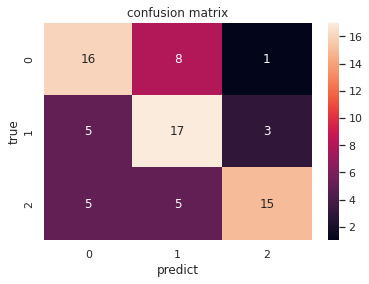

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
outputs_test = model(x_test)
_, prediction = torch.max(outputs_test, 1)

print('classification report: ')
print(classification_report(y_test,prediction,target_names=['Normal','Pneumonia','COVID-19']))
print('')

CM = confusion_matrix(y_test,prediction)
sns.set()
f,ax=plt.subplots()
print('confusion matrix: ')
sns.heatmap(CM,annot=True,ax=ax) 
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

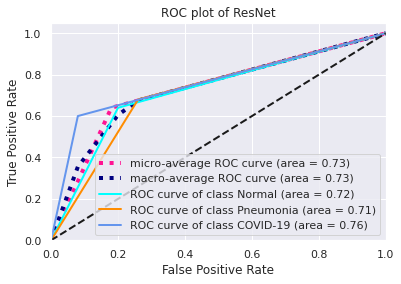

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import itertools 

def get_roc_auc(trues, preds):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #print(trues, preds)

  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)

  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  lw = 2
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)

  colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
  label_name = ['Normal','Pneumonia','COVID-19']

  for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(label_name[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC plot of ResNet')
  plt.legend(loc="lower right")
  plt.show()

test_trues = label_binarize(y_test, classes=[i for i in range(3)])
test_preds = label_binarize(prediction, classes=[i for i in range(3)])

get_roc_auc(test_trues, test_preds)

In [ ]:
#from google.colab import drive
#drive.mount('/content/MyDrive/')
#torch.save(model, '/content/MyDrive/MyDrive/DATA5703/code/model/ResNet_model.pt')

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#file_id = "1nJGvqQJJIXc4jSsINmA8N7M9YH_qgJ7B"
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('ResNet_model.pt')

#model = torch.load('ResNet_model.pt')